In [34]:
# --- Bloco 0: Importações ---
import pandas as pd
import numpy as np
import joblib # Para salvar os scalers

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn (para pré-processamento e métricas)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Optuna (para otimização de hiperparâmetros)
import optuna
import plotly.graph_objects as go
from optuna.trial import TrialState

# Outros
import math
import time
import matplotlib.pyplot as plt

# Configurações
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
torch.manual_seed(42)

Usando dispositivo: cpu


In [35]:
# --- Bloco 1: Definição da Arquitetura da Rede (Dinâmica) ---
# Este bloco define *como* construir a rede,
# mas ela será instanciada dinamicamente pelo Optuna.

class Net(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(Net, self).__init__()
        
        layers = []
        
        # Camada de entrada (1 feature: Potencia_MW)
        layers.append(nn.Linear(1, n_neurons))
        layers.append(nn.ReLU())
        
        # Camadas ocultas dinâmicas
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.ReLU())
            
        # Camada de saída (1 feature: Custo_Real)
        layers.append(nn.Linear(n_neurons, 1))
        
        # Compilar todas as camadas em um modelo sequencial
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("Definição da classe 'Net' concluída.")

Definição da classe 'Net' concluída.


In [36]:
# --- Bloco 2: Funções Auxiliares (Métricas e Complexidade) ---

def calculate_complexity(n_layers, n_neurons):
    """
    Calcula a métrica de complexidade customizada:
    log2(número de neurônios por camada) * número de camadas
    """
    if n_neurons == 0 or n_layers == 0:
        return 0
    return math.log2(n_neurons) * n_layers

def calculate_all_metrics(y_true, y_pred):
    """
    Calcula MSE, RMSE e MAPE.
    Espera arrays NumPy.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mape

print("Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.")

Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.


In [37]:
# --- Bloco 3: Carregamento e Normalização dos Dados ---

# Carregar o dataset
df = pd.read_csv('usina_carvao_dataset.csv')

# Preparar dados para o scaler
X = df[['Potencia_MW']].values
y = df[['Custo_Real']].values

# Inicializar os scalers
# Usamos dois scalers separados para podermos
# salvar ambos e usá-los no notebook MILP.
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# "Aprender" a escala dos dados e transformá-los
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Salvar os scalers para uso futuro!
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

print("Dados carregados e normalizados.")
print(f"Formato de X (Potência): {X_scaled.shape}")
print(f"Formato de y (Custo): {y_scaled.shape}")
print("\nScalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.")

Dados carregados e normalizados.
Formato de X (Potência): (5000, 1)
Formato de y (Custo): (5000, 1)

Scalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.


In [38]:
# --- Bloco 4: Separação Aleatória e DataLoaders ---
# Este bloco mistura os dados (shuffle=True) e os separa
# em conjuntos de treino e validação.

# Separar em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Converter dados NumPy para Tensores do PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

# Criar DataLoaders para treinamento em lote (batch)
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dados separados: {len(X_train_t)} amostras de treino, {len(X_val_t)} amostras de validação.")

Dados separados: 4000 amostras de treino, 1000 amostras de validação.


In [39]:
# --- Bloco 5: Definição da Função 'objective' do Optuna ---
# Este é o coração do notebook. Esta função será chamada
# dezenas de vezes pelo Optuna.

# Parâmetros do Treinamento
N_EPOCHS = 300       # Número de épocas que você definiu
EARLY_STOPPING_PATIENCE = 30 # Paciência que você pediu

def objective(trial):
    # --- 1. Sugerir Hiperparâmetros ---
    # Número de camadas (1 a 3)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    # Número de neurônios (3 a 20)
    n_neurons = trial.suggest_int('n_neurons', 3, 20)
    # Taxa de aprendizado
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    
    # --- 2. Calcular Complexidade e Armazenar ---
    complexity = calculate_complexity(n_layers, n_neurons)
    trial.set_user_attr('complexity', complexity)

    # --- 3. Construir Modelo e Otimizador ---
    model = Net(n_layers, n_neurons).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # Usamos MSE para o loss

    # --- 4. Loop de Treinamento com Early Stopping & Pruning ---
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(N_EPOCHS):
        # Treinamento
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validação
        model.eval()
        current_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                current_val_loss += loss.item() * X_batch.size(0)
        
        current_val_loss /= len(val_loader.dataset)
        
        # --- 5. Lógica de Pruning (pelo Optuna) ---
        trial.report(current_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # --- 6. Lógica de Early Stopping ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            # print(f"Trial {trial.number} parou cedo no epoch {epoch}")
            break
            
    # --- 7. Retornar Métrica de Qualidade (RMSE) ---
    # Optuna minimiza o valor retornado.
    # Usamos o RMSE (raiz do MSE) como métrica de seleção.
    final_rmse = math.sqrt(best_val_loss)
    trial.set_user_attr('val_rmse', final_rmse)
    
    return final_rmse

print("Função 'objective' do Optuna definida.")

Função 'objective' do Optuna definida.


In [40]:
'''
# --- Bloco 6: Execução do Estudo Optuna ---

print("--- Iniciando Estudo Optuna ---")
# Habilitar o Pruner (Poda) para cortar trials ruins
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\n--- Estudo Optuna Concluído ---")
print(f"Melhor trial: {study.best_trial.number}")
print(f"  Melhor RMSE de Validação: {study.best_value:.6f}")
print("  Melhores Hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
    
complexity = study.best_trial.user_attrs['complexity']
print(f"  Complexidade do Melhor Modelo: {complexity:.2f}")
'''

'\n# --- Bloco 6: Execução do Estudo Optuna ---\n\nprint("--- Iniciando Estudo Optuna ---")\n# Habilitar o Pruner (Poda) para cortar trials ruins\npruner = optuna.pruners.MedianPruner(n_warmup_steps=10)\n\nstudy = optuna.create_study(direction=\'minimize\', pruner=pruner)\nstudy.optimize(objective, n_trials=100, show_progress_bar=True)\n\nprint("\n--- Estudo Optuna Concluído ---")\nprint(f"Melhor trial: {study.best_trial.number}")\nprint(f"  Melhor RMSE de Validação: {study.best_value:.6f}")\nprint("  Melhores Hiperparâmetros:")\nfor key, value in study.best_params.items():\n    print(f"    {key}: {value}")\n    \ncomplexity = study.best_trial.user_attrs[\'complexity\']\nprint(f"  Complexidade do Melhor Modelo: {complexity:.2f}")\n'

In [41]:
'''
7# --- Bloco 7: Gráficos Elaborados do Optuna ---

print("Gerando gráficos do Optuna...")

# Gráfico 1: Histórico de Otimização (RMSE vs. Trial)
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

# Gráfico 2: Importância dos Hiperparâmetros
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

# Gráfico 3: Gráfico Customizado (Qualidade vs. Complexidade)
# Este é o gráfico que você pediu
trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
complexities = [t.user_attrs['complexity'] for t in trials]
val_rmses = [t.value for t in trials]
trial_numbers = [t.number for t in trials]

fig3 = go.Figure(data=go.Scatter(
    x=complexities,
    y=val_rmses,
    mode='markers',
    text=[f'Trial: {n}<br>RMSE: {r:.4f}<br>Complex: {c:.2f}' 
          for n, r, c in zip(trial_numbers, val_rmses, complexities)],
    marker=dict(
        color=val_rmses,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='RMSE de Validação')
    )
))
fig3.update_layout(
    title='Trade-off: Qualidade (RMSE) vs. Complexidade do Modelo',
    xaxis_title='Complexidade (log2(neurônios) * camadas)',
    yaxis_title='RMSE de Validação (Normalizado)',
    hovermode='closest'
)
fig3.show()
'''

'\n7# --- Bloco 7: Gráficos Elaborados do Optuna ---\n\nprint("Gerando gráficos do Optuna...")\n\n# Gráfico 1: Histórico de Otimização (RMSE vs. Trial)\nfig1 = optuna.visualization.plot_optimization_history(study)\nfig1.show()\n\n# Gráfico 2: Importância dos Hiperparâmetros\nfig2 = optuna.visualization.plot_param_importances(study)\nfig2.show()\n\n# Gráfico 3: Gráfico Customizado (Qualidade vs. Complexidade)\n# Este é o gráfico que você pediu\ntrials = [t for t in study.trials if t.state == TrialState.COMPLETE]\ncomplexities = [t.user_attrs[\'complexity\'] for t in trials]\nval_rmses = [t.value for t in trials]\ntrial_numbers = [t.number for t in trials]\n\nfig3 = go.Figure(data=go.Scatter(\n    x=complexities,\n    y=val_rmses,\n    mode=\'markers\',\n    text=[f\'Trial: {n}<br>RMSE: {r:.4f}<br>Complex: {c:.2f}\' \n          for n, r, c in zip(trial_numbers, val_rmses, complexities)],\n    marker=dict(\n        color=val_rmses,\n        colorscale=\'Viridis\',\n        showscale=True,

In [42]:
# --- Bloco 8: Treinamento Final da Rede "Campeã" ---
# Agora, pegamos os melhores hiperparâmetros e treinamos
# um modelo final do zero, salvando o histórico de loss.

print("--- Treinando a Rede 'Campeã' Final ---")

'''
best_params = study.best_params
BASE_N_LAYERS = best_params['n_layers']
BASE_N_NEURONS = best_params['n_neurons']
BASE_LR = best_params['lr']
#'''

# {'n_layers': 3, 'n_neurons': 20, 'lr': 0.016958810881878037}

#'''
BASE_N_LAYERS = 1
BASE_N_NEURONS = 37
BASE_LR = 0.026492546736443214
N_EPOCHS = 10
#'''

'''
BASE_N_LAYERS = 2
BASE_N_NEURONS = 13
BASE_LR = 0.008164828229766462
N_EPOCHS = 10
#'''

'''
BASE_N_LAYERS = 3
BASE_N_NEURONS = 20
BASE_LR = 0.016958810881878037
N_EPOCHS = 10
#'''

# Parâmetros da rede
final_model = Net(
    n_layers=BASE_N_LAYERS,
    n_neurons=BASE_N_NEURONS
).to(device)
final_lr = BASE_LR


optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
criterion = nn.MSELoss()

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

# Usar os mesmos parâmetros do Optuna
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
for epoch in range(N_EPOCHS):
    # Treinamento
    final_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    final_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(final_model.state_dict(), 'temp.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento final parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento final concluído em {end_time - start_time:.2f}s")
print("Modelo 'temp.pth' salvo.")

--- Treinando a Rede 'Campeã' Final ---
Treinamento final concluído em 0.91s
Modelo 'temp.pth' salvo.


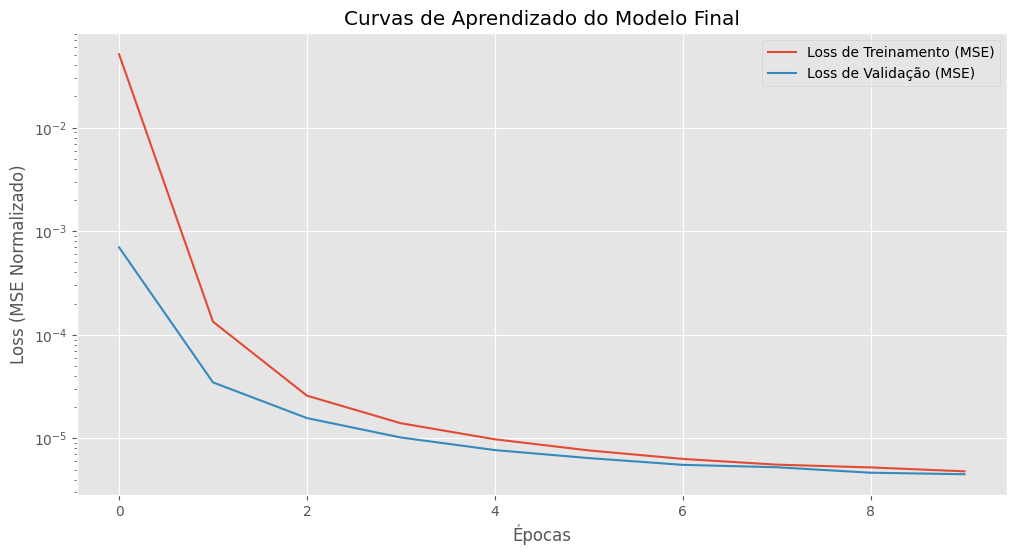

In [43]:
# --- Bloco 9: Gráfico de Treinamento (Loss vs. Epoch) ---

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Loss de Treinamento (MSE)')
plt.plot(val_losses, label='Loss de Validação (MSE)')
plt.title('Curvas de Aprendizado do Modelo Final')
#plt.ylim(0,0.0005)
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.yscale('log') # Usar escala logarítmica é quase obrigatório aqui
plt.legend()
plt.show()

--- Avaliação Final do Modelo ---

Métricas Finais (em escala real de R$):
  MSE:  1,493.80
  RMSE: 38.65
  MAPE: 0.0054 %


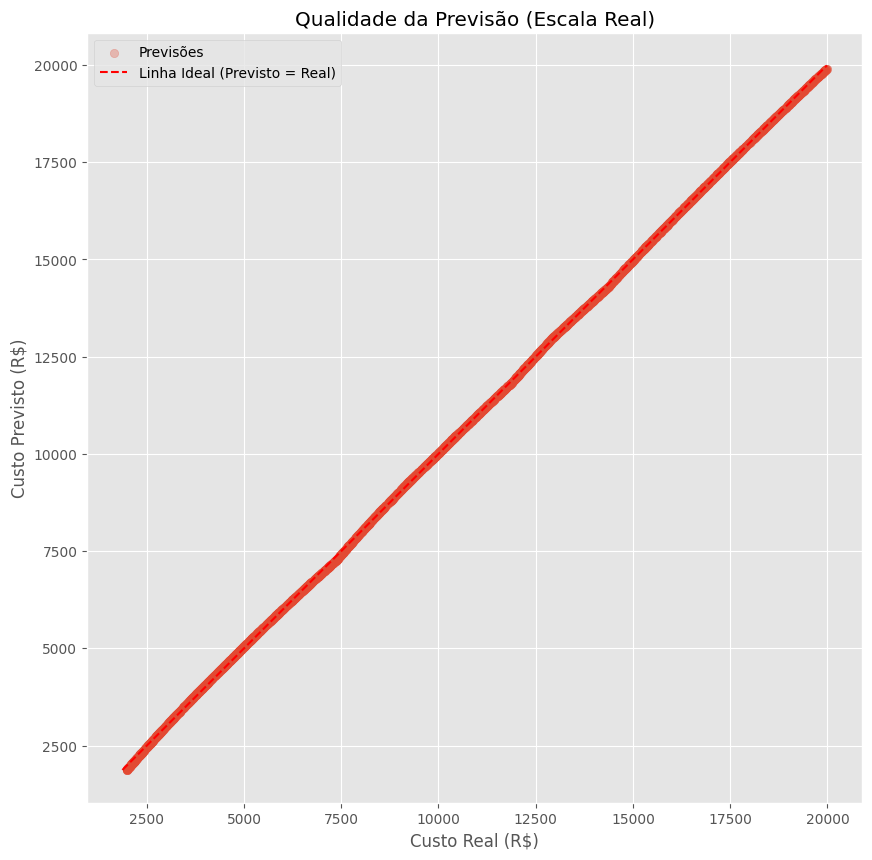

In [44]:
# --- Bloco 10: Avaliação Final (Métricas nos Dados Reais) ---

print("--- Avaliação Final do Modelo ---")

# Carregar o melhor modelo salvo
final_model.load_state_dict(torch.load('temp.pth'))
final_model.eval()

# Passar TODOS os dados (X_scaled) pelo modelo
with torch.no_grad():
    y_pred_scaled_t = final_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
# Agora avaliamos na escala de R$ e MW reais
y_true_real = y_scaler.inverse_transform(y_scaled)
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)
x_real = x_scaler.inverse_transform(X_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [45]:
# --- Bloco 5: Carregamento do Modelo Pré-Treinado ---

print("--- Iniciando Treinamento por Transferência ---")

# Re-criar a arquitetura EXATA do modelo base salvo
# (É crucial que os parâmetros sejam os mesmos)
MODEL_BASE_PATH = 'temp.pth'

# Instanciar o novo modelo
transfer_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)

# --- A MÁGICA (Transfer Learning) ---
# Carregar os pesos (o "conhecimento") do modelo de 10 épocas
transfer_model.load_state_dict(torch.load(MODEL_BASE_PATH))
# ------------------------------------

print(f"Modelo pré-treinado '{MODEL_BASE_PATH}' carregado com sucesso.")

# Configurar o otimizador para o novo modelo
optimizer = optim.Adam(transfer_model.parameters(), lr=BASE_LR)
criterion = nn.MSELoss()

--- Iniciando Treinamento por Transferência ---
Modelo pré-treinado 'temp.pth' carregado com sucesso.


In [46]:
# --- Bloco 6: Continuação do Treinamento (Epoch 11 até o fim) ---

print("--- Continuando o treinamento (Epochs 11 a 300) ---")

# Parâmetros
N_TOTAL_EPOCHS = 300
N_EPOCHS_JA_TREINADAS = 10
EARLY_STOPPING_PATIENCE = 30 # A mesma paciência

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
# Começamos o loop da época 11 até 300
for epoch in range(N_EPOCHS_JA_TREINADAS, N_TOTAL_EPOCHS):
    
    # Treinamento
    transfer_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = transfer_model(X_batch) # Usando o transfer_model
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    transfer_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = transfer_model(X_batch) # Usando o transfer_model
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(transfer_model.state_dict(), 'temp.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento por transferência parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0 or epoch == N_EPOCHS_JA_TREINADAS:
        # Imprime no primeiro loop (época 10) e a cada 50
        print(f"Epoch [{epoch+1}/{N_TOTAL_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento por transferência concluído em {end_time - start_time:.2f}s")
print("Modelo 'temp.pth' salvo.")

--- Continuando o treinamento (Epochs 11 a 300) ---
Epoch [11/300], Train Loss: 0.004046, Val Loss: 0.000036
Epoch [50/300], Train Loss: 0.000040, Val Loss: 0.000018
Treinamento por transferência parou cedo no epoch 72
Treinamento por transferência concluído em 4.99s
Modelo 'temp.pth' salvo.


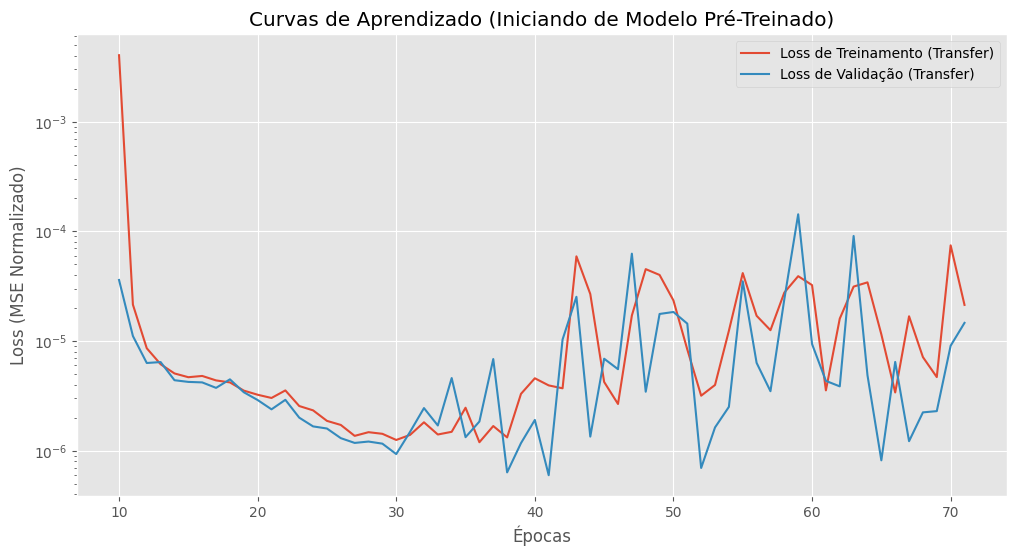

In [47]:
# --- Bloco 7: Gráfico de Treinamento (Loss vs. Epoch) ---
# Este gráfico será a prova: ele vai começar BAIXO.

plt.figure(figsize=(12, 6))
# Plotar o loss a partir da época 11
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(train_losses)), 
         train_losses, 
         label='Loss de Treinamento (Transfer)')
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(val_losses)), 
         val_losses, 
         label='Loss de Validação (Transfer)')

plt.title('Curvas de Aprendizado (Iniciando de Modelo Pré-Treinado)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.legend()
plt.yscale('log')
plt.show()

--- Avaliação Final do Modelo de Transferência ---

Métricas Finais (em escala real de R$):
  MSE:  201.31
  RMSE: 14.19
  MAPE: 0.0016 %


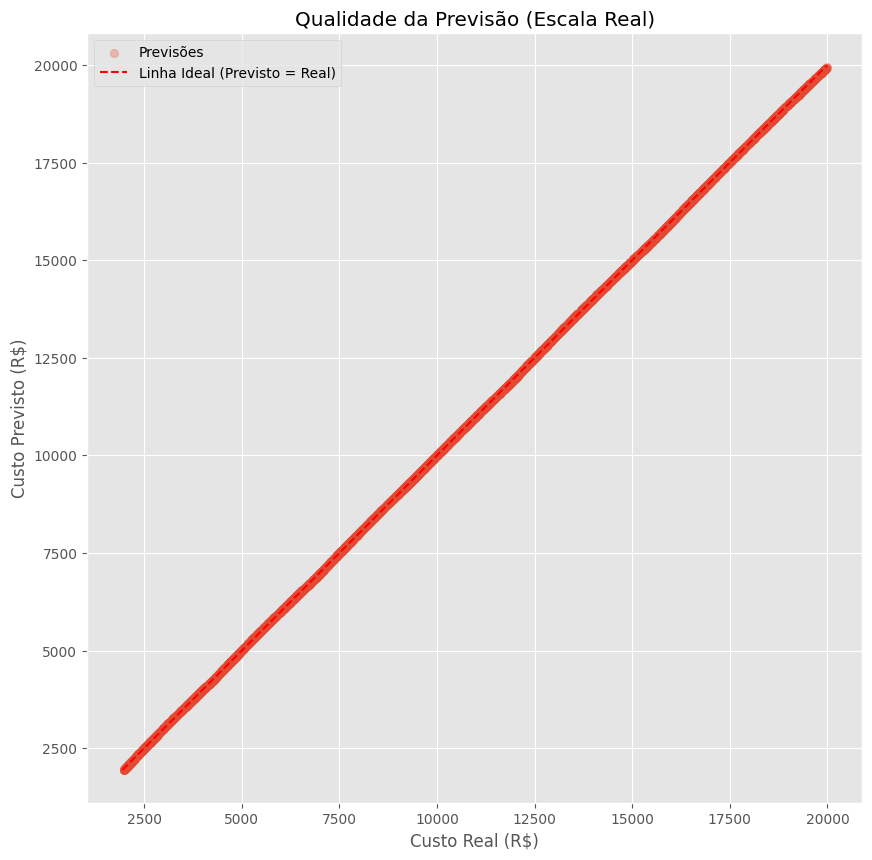

In [48]:
# --- Bloco 8: Avaliação Final (Métricas nos Dados Reais) ---
# Este bloco é idêntico ao Bloco 10 do notebook original,
# apenas carrega o 'temp.pth'

print("--- Avaliação Final do Modelo de Transferência ---")

# Carregar os scalers
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')

# Carregar os dados originais (não normalizados)
X = pd.read_csv('usina_carvao_dataset.csv')[['Potencia_MW']].values
y_true_real = pd.read_csv('usina_carvao_dataset.csv')[['Custo_Real']].values

# Carregar o melhor modelo salvo
eval_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
eval_model.load_state_dict(torch.load('temp.pth'))
eval_model.eval()

# Preparar dados de entrada (normalizar)
X_scaled = x_scaler.transform(X)

# Passar TODOS os dados pelo modelo
with torch.no_grad():
    y_pred_scaled_t = eval_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [49]:
# --- Bloco 11: Visualização do Modelo Final ("Campeão") com TensorBoard ---
# Este bloco usa SummaryWriter do PyTorch para logar o grafo do modelo,
# garantindo que a arquitetura visualizada seja a mesma que foi treinada no Bloco 8.
# Nota: Você precisa ter 'tensorboard' instalado (`pip install tensorboard`)

print("\n--- Logando Grafo da Rede 'Campeã' para TensorBoard ---")

try:
    from torch.utils.tensorboard import SummaryWriter

    # --- MUDANÇA AQUI ---
    # 1. Usar as variáveis BASE_N_LAYERS e BASE_N_NEURONS definidas no Bloco 8
    #    Estas variáveis contêm a arquitetura da rede campeã encontrada pelo Optuna.
    #    Certifique-se de que o Bloco 8 foi executado e essas variáveis existem.
    
    # Verificar se as variáveis existem (caso execute fora de ordem)
    if 'BASE_N_LAYERS' not in locals() or 'BASE_N_NEURONS' not in locals():
         raise NameError("Variáveis BASE_N_LAYERS ou BASE_N_NEURONS não definidas. Execute o Bloco 8 primeiro.")

    # Instanciar o modelo com a arquitetura correta
    #tb_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
    tb_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
    
    # Nome do arquivo do modelo salvo no Bloco 8
    # Certifique-se que este nome corresponde ao arquivo salvo no Bloco 8
    # (No seu código anterior era 'temp.pth')
    SAVED_MODEL_FILENAME = 'temp.pth' 
    
    # Carregar os pesos do modelo campeão
    tb_model.load_state_dict(torch.load(SAVED_MODEL_FILENAME))
    tb_model.eval()
    # --- Fim da Mudança ---

    # 2. Criar um dado de entrada falso (dummy input) com batch size pequeno
    dummy_input_tb = torch.randn(BATCH_SIZE, 1).to(device) # Usar batch_size=1 para o gráfico mais limpo

    # 3. Criar o SummaryWriter
    log_dir = "runs/diagrama_rede_relu_1_layer" # Mesmo diretório
    writer = SummaryWriter(log_dir)

    # 4. Adicionar o grafo ao TensorBoard
    writer.add_graph(tb_model, dummy_input_tb)

    # 5. Fechar o writer
    writer.close()

    print(f"Grafo do modelo '{SAVED_MODEL_FILENAME}' logado com sucesso em: '{log_dir}'")
    print("Para visualizar, abra o terminal e execute:")
    print(f"python -m tensorboard.main --logdir={log_dir}")
    print("Depois, acesse o endereço (geralmente http://localhost:6006/) no seu navegador.")


except ImportError:
    print("Biblioteca 'tensorboard' não encontrada. Instale com 'pip install tensorboard'.")
except NameError as e:
    print(f"Erro: {e}")
except FileNotFoundError:
     print(f"ERRO: Arquivo do modelo '{SAVED_MODEL_FILENAME}' não encontrado.")
     print("Verifique o nome do arquivo salvo no Bloco 8.")
except Exception as e:
    print(f"Erro ao logar grafo para TensorBoard: {e}")


# python -m tensorboard.main --logdir=runs/diagrama_rede_relu_3_layers
# python -m tensorboard.main --logdir=runs/diagrama_rede_relu_2_layers
# python -m tensorboard.main --logdir=runs/diagrama_rede_relu_1_layer


--- Logando Grafo da Rede 'Campeã' para TensorBoard ---
Grafo do modelo 'temp.pth' logado com sucesso em: 'runs/diagrama_rede_relu_1_layer'
Para visualizar, abra o terminal e execute:
python -m tensorboard.main --logdir=runs/diagrama_rede_relu_1_layer
Depois, acesse o endereço (geralmente http://localhost:6006/) no seu navegador.
